In [1]:
from sklearn.metrics.pairwise import pairwise_distances
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dateutil import parser
import datetime

###Lat/Lon

In [5]:
#load unique cities csv
df_cities = pd.read_csv("4942_count_sightings_ST.csv",index_col=0)
#del df_cities['Unnamed: 0']
df_cities['dist_comp'] = pd.Series()

In [8]:
df_cities.head()

,CityST,AirportDist,pop,lon,lat,BaseDist,count,per_capita,ST,dist_comp
0,"Surfside Beach, SC",9.187467,3898.894737,-78.973275,33.606370,7.512232,38,0.009746,SC,NaN
1,"Shallotte, NC",12.265988,3675.000000,-78.327025,33.926678,31.688831,32,0.008707,NC,NaN
2,"Myrtle Beach, SC",3.959324,26351.031250,-78.891014,33.695258,5.820015,224,0.008501,SC,NaN
3,"Mount Vernon, KY",9.595759,2597.636364,-84.499587,38.039751,45.912659,22,0.008469,KY,NaN
4,"North Myrtle Beach, SC",4.085878,13528.767857,-78.678858,33.822749,29.389271,112,0.008279,SC,NaN


In [3]:
#load full csv
full_df = pd.read_csv("52150_locations_USA_census_nonull.csv")
del full_df['Unnamed: 0']

In [9]:
subset = df_cities[['lat', 'lon']]

t = time.time()

d = pairwise_distances(subset)

drr = d.ravel()
print drr.mean()

18.6554109896


In [32]:
subset = df_cities[['lat', 'lon']] #my lat/long

t = time.time() #timing

d = pairwise_distances(subset) #find pairwise distances between (lat,lon)
print("Shape",d.shape)

d_bool = d < .3 #close obs are less than .35 away from each other, assign true if so

g = nx.from_numpy_matrix(d_bool) #make my components ???

print("Number of comps",nx.number_connected_components(g))

print
print("Runtime",time.time()-t)
print

comps = [_ for _ in nx.connected_components(g)]
length_of_comps = [len(_) for _ in comps]
length_of_comps = pd.Series(length_of_comps)

('Shape', (4942, 4942))
('Number of comps', 1067)

('Runtime', 1.7451629638671875)



In [33]:
comps[90]

{146}

In [31]:
for ind in comps[1]:
    print df_cities.ix[ind].CityST

Mount Vernon, KY
Lawrenceburg, IN
Stow, OH
Delaware, OH
Lorain, OH
Coshocton, OH
Marine City, MI
Kentwood, MI
Shepherdsville, KY
Johnstown, OH
Versailles, KY
Fremont, OH
Rittman, OH
Jefferson, OH
Highland Heights, OH
Cleveland, OH
Oregon, OH
New Carlisle, OH
Dearborn Heights, MI
Corydon, IN
New Albany, IN
Garfield Heights, OH
Charlestown, IN
Fishers, IN
Fenton, MI
Springville, NY
Grandview Heights, OH
Harper Woods, MI
Romulus, MI
Fulton, NY
Crafton, PA
Bellevue, KY
Anderson, IN
Canastota, NY
Grand Rapids, MI
Mount Washington, KY
Bethel, OH
New Baltimore, MI
Orchard Park, NY
Blue Ash, OH
Brighton, MI
Taylor Mill, KY
Brackenridge, PA
North Manchester, IN
Batavia, NY
Little Falls, NY
Lake Orion, MI
Canonsburg, PA
Scottsburg, IN
Bucyrus, OH
Madison Heights, MI
New Haven, IN
Hartford City, IN
Avon, IN
Grove City, OH
Vine Grove, KY
Corry, PA
Richmond, IN
Churchill, PA
Mansfield, OH
Rochester, NY
Wyandotte, MI
Piqua, OH
Oxford, MI
Kalamazoo, MI
Speedway, IN
Brunswick, OH
Mount Gilead, OH
Balt

In [6]:
#assign comp number to obs row
for i in range(len(length_of_comps)):
    for ind in comps[i]:
        df_cities.set_value(ind,9,i,takeable = True)

In [7]:
merged = pd.merge(full_df,df_cities[['CityST','dist_comp']],how='inner',on='CityST')

###Date

In [102]:
test_df_comp1 = merged[merged['dist_comp']==1]
len(test_df_comp1)

5609

In [103]:
subset = test_df_comp1[['duration_seconds']]

d = pairwise_distances(subset) #find pairwise distances between duration in seconds

dr = d.ravel()
print dr.mean()

1376.57987518


In [104]:
t = time.time()
print("Shape",d.shape)
d_bool = d < 5 #close obs are less than 5 seconds difference from each other, assign true if so
g = nx.from_numpy_matrix(d_bool) 
print("Number of comps",nx.number_connected_components(g))

print
print("Runtime",time.time()-t)
print

comps = [_ for _ in nx.connected_components(g)]
length_of_comps = [len(_) for _ in comps]
length_of_comps = pd.Series(length_of_comps)

('Shape', (5609, 5609))
('Number of comps', 65)

('Runtime', 16.881983995437622)



In [105]:
dr_pd = pd.Series(dr)

In [ ]:
for i in range(len(length_of_comps)):    
    for ind in comps[i]:
        print subset.iloc[ind]

In [107]:
test_df_comp1.date_datetime.shape

(5609,)

In [119]:
merged.columns

Index([u'city', u'shape', u'duration', u'state', u'link', u'date',
       u'date_datetime', u'duration_seconds', u'day', u'link_no_ext', u'lat',
       u'long', u'pre2015', u'daylight', u'USA', u'lat_', u'long_', u'city_',
       u'district_', u'state_', u'country_', u'AirportDist', u'BaseDist',
       u'census_year', u'ID', u'City', u'ST', u'CityST', u'Name_2010',
       u'County', u'LAT', u'LON', u'year', u'pop', u'yr_of_sighting',
       u'dist_comp'],
      dtype='object')

In [122]:
len(merged.dist_comp.unique())

770

In [51]:
parsed = parser.parse(merged['date_datetime'][0])

In [8]:
def to_seconds(x):
    t = datetime.datetime(1900,1,1)
    return (parser.parse(x) - t).total_seconds()

def to_ordinal(x):
    return parser.parse(x).toordinal()

In [12]:
merged['seconds'] = merged['date_datetime'].map(lambda x: to_seconds(x))

In [142]:
#subset = merged[['day']]
#subset = unique_days
subset_df = merged[merged['dist_comp']==1].reset_index()
subset = subset_df[['bin_seconds']]

d = pairwise_distances(subset) #find pairwise distances between duration in seconds

dr = d.ravel()
print dr.mean()

3726.15605342


In [152]:
t = time.time()
print("Shape",d.shape)
d_bool = d < 1 #close obs are less than 2 bins difference from each other, assign true if so
g = nx.from_numpy_matrix(d_bool) 
print("Number of comps",nx.number_connected_components(g))

print
print("Runtime",time.time()-t)
print

comps = [_ for _ in nx.connected_components(g)]
length_of_comps = [len(_) for _ in comps]
length_of_comps = pd.Series(length_of_comps)

('Shape', (5609, 5609))
('Number of comps', 3407)

('Runtime', 0.5077390670776367)



In [156]:
drp = pd.Series(dr)

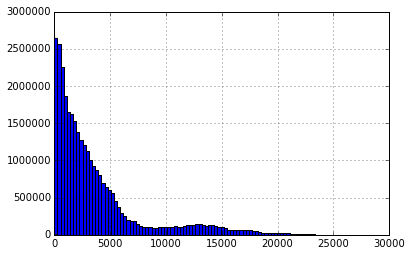

In [157]:
drp.hist(bins=100)

###Bin things

In [10]:
labels = range(100)

#bin distance to Airport and Military bases
bins_airport = pd.cut(full_df.AirportDist,100,labels=labels)
bins_military = pd.cut(full_df.BaseDist,100,labels=labels)

In [13]:
bins = 30000
labels_seconds = range(bins)
bins_seconds = pd.cut(merged.seconds,bins, labels=labels_seconds)

In [14]:
merged['bin_seconds'] = bins_seconds

In [15]:
merged.head()

,city,shape,duration,state,link,date,date_datetime,duration_seconds,day,link_no_ext,...,Name_2010,County,LAT,LON,year,pop,yr_of_sighting,dist_comp,seconds,bin_seconds
0,Mokena,circle,30 seconds,IL,121/S121083.html,8/13/15 21:00,2015-08-13 21:00:00,30,735823,121/S121083,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2015,52,3648488400,29999
1,Mokena,cigar,1-3 minutes,IL,108/S108589.html,4/12/14 21:35,2014-04-12 21:35:00,180,735335,108/S108589,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2014,52,3606327300,29500
2,Mokena,unknown,15-20 minutes,IL,102/S102620.html,9/24/13 19:45,2013-09-24 19:45:00,1200,735135,102/S102620,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2013,52,3589040700,29295
3,Mokena,circle,15-20 minutes,IL,089/S89213.html,5/26/12 21:00,2012-05-26 21:00:00,1200,734649,089/S89213,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2012,52,3547054800,28797
4,Mokena,light,20 sec,IL,083/S83822.html,9/9/11 23:05,2011-09-09 23:05:00,20,734389,083/S83822,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2011,52,3524598300,28531


In [112]:
group_by_year = merged.groupby('yr_of_sighting')

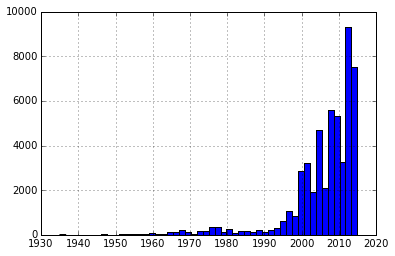

In [118]:
merged.yr_of_sighting.hist(bins=50)

###Aggregate

In [43]:
merged['bin_seconds'] = merged['bin_seconds'].astype(int) #convert bin_seconds from categorical var

In [45]:
agg = merged.groupby(['bin_seconds','dist_comp']) #groupby time bin and location bin

In [80]:
counts = pd.DataFrame(agg.size()).reset_index()
counts=counts.rename(columns = {0:'counts'})

In [81]:
counts.head()

,bin_seconds,dist_comp,counts
0,0,103,1
1,847,103,1
2,1554,462,1
3,1893,1,1
4,2541,103,1


###Merge this

In [82]:
print len(merged)
print len(counts)

52147
41757


In [83]:
new_merged = pd.merge(merged,counts,how="inner",on=['bin_seconds','dist_comp'])

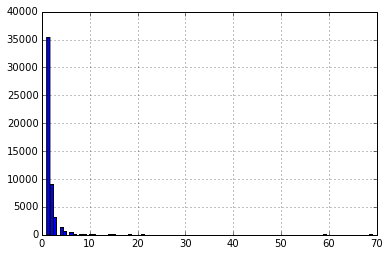

In [88]:
new_merged.counts.hist(bins=100)

In [89]:
new_merged.to_csv("52147_reliability_count.csv",encoding="utf-8")

In [ ]:
results = []
for n in range(1,21):
    k = KNeighborsClassifier(n_neighbors=n)
    k.fit(X_train,y_train)
    results.append(accuracy_score(k.predict(X_test),y_test))
    print("Accuracy at k={0}: {1:0.4f}".format(n,accuracy_score(k.predict(X_test),y_test)))

k_best = results.index(max(results))+1
print("\nMax accuracy score of {0:0.4f} with k-value {1}".format(max(results),duplicates(results,max(results))))